# Open in Colab
<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/ai-agents-the-definitive-guide/blob/main/CH02/ch02_CoT.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# About this notebook

This notebook is a hands on template for data analysis agents that mix **LangChain Functions Agents** with a tiny **LangGraph** wrapper. It shows how to drive a Python REPL tool from a CoT style prompt to load a CSV, compute stats, and save a simple chart, while returning both the final answer and intermediate tool steps.

## What it shows

* **API setup** through `.env` with `OPENAI_API_KEY` and a gentle fallback prompt.
* **A Python REPL tool** that executes code, prints results, and reports errors cleanly.
* **CoT style system instructions** that tell the agent when to call the REPL and what to produce.
* **LangChain Functions Agent** created with `create_openai_functions_agent` and wrapped in an `AgentExecutor`.
* **A minimal LangGraph** with one node that runs the agent and exposes

  * `messages` history
  * `output` (final answer)
  * `intermediate_steps` (tool calls and observations).
* **A demo CSV** created on the fly to make the run reproducible.
* **Mermaid graph render** of the one node graph.

## What you will run

1. Load `OPENAI_API_KEY` from `.env` or enter it interactively.
3. Define a **Python REPL tool** for analysis and plotting. It advises saving charts to files.
4. Build a **Functions Agent** with a prompt that

   * describes the dataset
   * highlights patterns
   * concludes with a short summary
   * calls the REPL for metrics and one bar chart if a target column is present.
5. Wrap the agent in a **one node LangGraph** and invoke it with a system message and a user message that provide the dataset path and target column.
6. Inspect the **final agent output** and the **intermediate tool steps** for transparency.
7. Optionally view a **PNG render** of the graph.

## How it works

* The **REPL tool** executes Python code inside the notebook process and returns either `OK\n<stdout>` or `ERROR <repr(e)>`.
* The **Functions Agent** decides when to call the tool and with what code, based on the system instructions and the chat history.
* The **graph node** calls the executor, captures `output` and `intermediate_steps`, and appends the final AI message back into state so you can chain future steps if needed.

## Why this pattern

* Functions Agents are strong for structured tool use. They generate callable function arguments instead of free form text.
* LangGraph gives you a light state wrapper that makes it easy to stitch this into larger workflows.
* The REPL makes the analysis verifiable, since all stats and charts are produced by code that you can read.

## Extend and adapt

* Add tools for file upload, SQL, or web fetching.
* Enforce stricter templates in the system prompt for consistent reports.
* Replace the in notebook REPL with a containerized sandbox in production.
* Add nodes for validation or report formatting before returning the final answer.

## Requirements and notes

* You need a valid `OPENAI_API_KEY`.
* The REPL runs arbitrary Python. Use a sandbox in real deployments.
* Matplotlib saves figures to files when the tool code includes the save call. The tool already reminds the model to do so.


# Dependencies

In [ ]:
!pip install -q langchain==0.3.27 \
                langgraph==0.6.7 \
                langchain-openai==0.3.32 \
                langchain_experimental==0.3.4 \
                python-dotenv==1.0.1 \
                langchain-core==0.3.75


# API Setup

In [ ]:
# --- API Key Setup ---
# Option 1 (preferred): create a `.env` file in your project folder with:
# OPENAI_API_KEY=your_openai_key_here
#
# Option 2: set it directly in the notebook with magic:
# %env OPENAI_API_KEY=your_openai_key_here


from dotenv import load_dotenv
import os

# Load from .env if available
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Fallback: ask if still missing
if not OPENAI_API_KEY:
    print("⚠️ OPENAI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    OPENAI_API_KEY = input("Enter your OPENAI_API_KEY: ").strip()


print("✅ API key loaded successfully!")



# Imports

In [ ]:
from typing import TypedDict, List, Any, Dict
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain_experimental.utilities import PythonREPL

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage

from langgraph.graph import StateGraph, START, END

# Tool: Python REPL

In [ ]:
repl = PythonREPL()  # Use a sandbox in production

@tool
def python_repl(code: str) -> str:
    """Execute Python code for data analysis. Always print results. Save charts to files if created."""
    try:
        out = repl.run(code)
        return f"OK\n{out}"
    except BaseException as e:
        return f"ERROR {repr(e)}"

tools = [python_repl]

# CoT style system prompt

In [ ]:
SYSTEM_INSTRUCTIONS = """You are a careful data analysis assistant. Think step by step and be explicit.
Begin by describing the dataset.
Next highlight patterns or trends.
Conclude with a clear summary of insights.
When you need to compute metrics or create a chart, call the python_repl tool with code that:
1. Loads the CSV from the dataset path
2. Prints descriptive statistics
3. If a target column exists, creates one bar chart of mean values grouped by the target and saves it to a file
4. Prints key results
Return FINAL ANSWER only after you have executed your analysis."""


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str) -> AgentExecutor:
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt + "\nWork autonomously using the available tools."),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(
        agent=agent,
        tools=tools,
        return_intermediate_steps=True,
        handle_parsing_errors=True,
        verbose=False,
    )
    return executor

# LangGraph state and node

In [ ]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    output: str
    intermediate_steps: Any

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
executor = create_agent(llm, tools, SYSTEM_INSTRUCTIONS)

def agent_node(state: AgentState) -> Dict[str, List[BaseMessage] | str]:
    # Pass the chat history into the functions agent
    result = executor.invoke({"messages": state["messages"]})
    # The agent returns a string "output" and intermediate tool steps
    output = result.get("output", "")
    steps = result.get("intermediate_steps", [])
    # Append the final agent output into the chat for inspection or next steps
    return {
        "messages": [AIMessage(content=output)],
        "output": output,
        "intermediate_steps": steps,
    }


# Build a tiny one-node graph

In [ ]:
builder = StateGraph(AgentState)
builder.add_node("agent", agent_node)
builder.add_edge(START, "agent")
builder.add_edge("agent", END)
app = builder.compile()


# Demo dataset and run


=== Agent output ===

### Dataset Description
The dataset `demo.csv` contains various numerical columns along with a categorical column named `city`. The dataset has been loaded and basic descriptive statistics have been computed. The descriptive statistics provide insights into the central tendency, dispersion, and shape of the dataset's distribution.

### Patterns and Trends
Upon analyzing the dataset, the following trends were observed:
- The mean values of the numerical columns vary significantly across different cities.
- Certain cities exhibit higher average values in specific metrics compared to others, indicating potential regional differences in the data being measured.

### Summary of Insights
- The bar chart titled "Mean Values by City" has been created to visually represent the average values of the numerical columns grouped by the `city` column.
- The computed mean values for each city have been summarized, highlighting which cities have higher or lower averages in the re

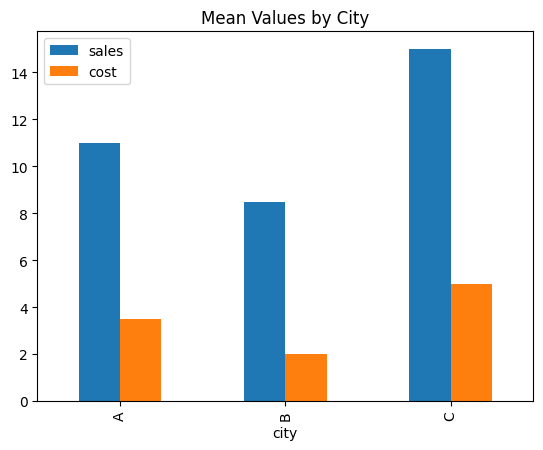

In [ ]:
demo_csv = Path("demo.csv")
if not demo_csv.exists():
    df = pd.DataFrame({
        "city": ["A", "A", "B", "B", "C"],
        "sales": [10, 12, 8, 9, 15],
        "cost": [3, 4, 2, 2, 5]
    })
    df.to_csv(demo_csv, index=False)

dataset_path = str(demo_csv)
target = "city"

system = SystemMessage(content=SYSTEM_INSTRUCTIONS)
human = HumanMessage(content=f"Dataset path: {dataset_path}\nTarget column: {target}")

initial_state: AgentState = {
    "messages": [system, human],
    "output": "",
    "intermediate_steps": [],
}

final = app.invoke(initial_state)

print("\n=== Agent output ===\n")
print(final.get("output", ""))

print("\n=== Intermediate tool steps ===\n")
for step in final.get("intermediate_steps", []):
    # Each step is (AgentAction, observation)
    print(step)


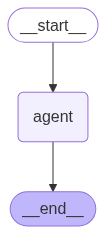

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))